In [1]:
# Wind Module
import time
# Start the script run timer
script_start_time = time.time()

In [2]:
resource_type:str="wind" #use all small letters

In [3]:
import logging as log
import os
import argparse
import atlite
import geopandas as gpd
import pandas as pd

In [31]:
# import Local Packages
from linkingtool import linking_utility as utils
from linkingtool import linking_vis as vis
from linkingtool import linking_wind as wind

log_path=f'workflow/log/{resource_type}_module_log.txt'
log=utils.create_log(log_path)

In [5]:
utils.print_module_title(f'{resource_type} Module Initiated')
log.info(f"Loading Configuration Data and Directories...")

2024-09-18 11:54:18 - INFO - Loading Configuration Data and Directories...


____________________________________________________________
     wind Module Initiated
____________________________________________________________


In [6]:
# '''--------- for notebook run purposes 
config_file_path='config/config_master.yml'
# '''
# def main(config_file_path:str):

In [7]:
# User Configuration

config:dict[dict]=utils.load_config(config_file_path)

current_region:dict = config['regional_info']['region_1']
_CRC_=current_region['code'] # Current Region Code i.e. BC

disaggregation_config:dict=config['capacity_disaggregation']

linking_data:dict=config['processed_data']['linking']
vis_dir:str=os.path.join(config['visualization']['linking'],resource_type)

resource_landuse_intensity = disaggregation_config[f'{resource_type}']['landuse_intensity'] # (MW/km2) from literature 1.7 MW/km2

ATB_NREL_cost_datafile=disaggregation_config[f'{resource_type}']['cost_data']
land_based_wind_cost=pd.read_csv(ATB_NREL_cost_datafile)

# Set COST parameters (global for PV)
wind_fom=land_based_wind_cost[land_based_wind_cost['core_metric_parameter']=='Fixed O&M'].value.iloc[0]/1E3  # mill. $/MW = ($/kw ) /1E3
print(f"Wind Site FOM set to: {round(wind_fom,2)} Mil. USD/ MW. Sourced from >> Summary data, Land-based Wind Turbine Cost, ATB 2024 , NREL ")

wind_capex=land_based_wind_cost[land_based_wind_cost['core_metric_parameter']=='CAPEX'].value.iloc[0]/1E3 # mill. $/MW = ($/kw ) /1E3
print(f"Wind Site CAPEX set to: {round(wind_capex,2)} Mil. USD/ MW. Sourced from >> Summary data, Land-based Wind Turbine Cost, ATB 2024 , NREL ")

wind_vom=0

grid_connection_cost_per_Km = disaggregation_config['transmission']['grid_connection_cost_per_Km'] #M$/km   # from MISO , may try NREL method for different range of distance
tx_line_rebuild_cost = disaggregation_config['transmission']['tx_line_rebuild_cost']  #M$/km # from MISO

grid_node_proximity_filter = disaggregation_config['transmission']['proximity_filter']
wcss_tolerance=disaggregation_config[f'{resource_type}']['WCSS_tolerance']
province_gwa_cells = os.path.join(linking_data['root'],resource_type,linking_data[f'{resource_type}']['gwa_cells_raw'])
turbine_model= disaggregation_config[f'{resource_type}']['turbines']['OEDB']['model_2'] 
turbine_config_file=disaggregation_config[f'{resource_type}']['turbines']['OEDB']['model_2']['config'] # to be automated
gadm_file=os.path.join(config['GADM']['root'],config['GADM']['datafile'])

# Raster Configurations
GAEZ_data:dict= config['GAEZ']
rasters_in_use_direct =GAEZ_data['Rasters_in_use_direct']

land_cover_config = GAEZ_data['land_cover']
terrain_resources_config = GAEZ_data['terrain_resources']
# exclusion_areas_config =GAEZ_data['exclusion_areas']

# Raster Files
gaez_landcover_raster = os.path.join(GAEZ_data['root'], rasters_in_use_direct, land_cover_config['zip_extract_direct'], land_cover_config['raster'])
gaez_terrain_raster = os.path.join(GAEZ_data['root'], rasters_in_use_direct, terrain_resources_config['zip_extract_direct'], terrain_resources_config['raster'])
# gaez_exclusionAreas_raster = os.path.join(parent_direct, rasters_in_use_direct, exclusion_areas_config['zip_extract_direct'], exclusion_areas_config['raster'])

# Raster class and buffer information 
land_class_inclusion = land_cover_config['class_inclusion'][f'{resource_type}']  #inclusion layer
terrain_class_exclusion= terrain_resources_config['class_exclusion'][f'{resource_type}'] #exclusion layer
# terrain_class_exclusion_buffer=terrain_resources_config['class_exclusion']['buffer'][f'{resource_type}'] #m

aeroway_file_path=os.path.join(linking_data['root'],resource_type,f"aeroway_OSM_{_CRC_}_with_buffer_{resource_type}.parquet")
# exclusionAreas__class_exclusion= exclusion_areas_config['class_exclusion'][f'{resource_type}']  #exclusion layer
# exclusionAreas__class_exclusion_buffer=exclusion_areas_config['class_exclusion']['buffer'][f'{resource_type}'] #m

Wind Site FOM set to: 0.04 Mil. USD/ MW. Sourced from >> Summary data, Land-based Wind Turbine Cost, ATB 2024 , NREL 
Wind Site CAPEX set to: 1.74 Mil. USD/ MW. Sourced from >> Summary data, Land-based Wind Turbine Cost, ATB 2024 , NREL 


In [8]:
# Load data-files
## Regional Boundary Data --------------------------------------------------------
log.info(F"Loading GADM's regional boundary data")
gadm_regions_gdf = gpd.read_file(gadm_file)
aeroway_with_buffer=gpd.read_parquet(aeroway_file_path)
conservation_lands_province_datafile:str= os.path.join(linking_data['root'],linking_data['CPCAD_org'])
## gov_conservation_lands_consideration=config['Gov']['conservation_lands']['consideration'][f'{resource_type}']
conservation_lands_province=gpd.read_parquet(conservation_lands_province_datafile)

log.info(F"Loading Transmission Nodes' data")
buses_gdf = gpd.GeoDataFrame(pd.read_pickle(os.path.join('data/processed_data',linking_data['transmission']['nodes_datafile'])))

2024-09-18 11:54:19 - INFO - Loading GADM's regional boundary data
2024-09-18 11:54:19 - INFO - Loading Transmission Nodes' data


In [9]:
## load ERA5 Cutout

log.info(f"Loading ERA5 Cutout...")

''' replaced with different strategy, to sync with pypsa
start_date = str(cutout_year)+"-01-01"
end_date = str(cutout_year)+"-12-31"
cutout=atlite.Cutout(os.path.join(config['cutout']['directory'],f"{_CRC_}_{cutout_year}.nc"))
start_date = str(cutout_year)+"-01-01"
end_date = str(cutout_year)+"-12-31"
'''
start_date = config['cutout']['snapshots']['start'][0] # 2021-01-01 07:00:00
end_date = config['cutout']['snapshots']['end'][0] # 2022-01-01 06:00:00

# cutout=atlite.Cutout(os.path.join(config['cutout']['directory'],f"{_CRC_}_{cutout_year}.nc"))
cutout=atlite.Cutout('data/downloaded_data/cutout/BC_2021_2022.nc')

2024-09-18 11:54:19 - INFO - Loading ERA5 Cutout...


In [10]:
# 1 Extract BC Grid Cells from Cutout using Regional Boundaries from GADM
province_grid_cells = cutout.grid.overlay(gadm_regions_gdf, how='intersection',keep_geom_type=True)
log.info(f"Extracted {len(province_grid_cells)} ERA5 Grid Cells for BC from Cutout")

2024-09-18 11:54:20 - INFO - Extracted 2956 ERA5 Grid Cells for BC from Cutout


2024-09-18 11:54:20 - INFO - Calculating land availability by -  Excluding terrain  with >30% slope...


The eligibility share is: 53.96%


Compute availability matrix: 100%|██████████| 1/1 [00:04<00:00,  4.24s/ gridcells]
2024-09-18 11:54:28 - INFO - Calculated Land Availability data loaded for  1817 Cells in Col.:2_land_avail_low_slop.

2024-09-18 11:54:29 - INFO - Calculating land availability by -  Eligible Land Classes...



Region of Interest : BC
 > Eligible Land Area of the  Grid Cells = 461,059 Km²
 > Actual Land Area : 944,735 km²

The eligibility share is: 54.39%


Compute availability matrix: 100%|██████████| 1/1 [00:04<00:00,  4.18s/ gridcells]
2024-09-18 11:54:37 - INFO - Calculated Land Availability data loaded for  1567 Cells in Col.:3_land_avail_eligible.

2024-09-18 11:54:37 - INFO - Calculating land availability by - Excluding Conservation and Protected lands by Canadian Gov....



Region of Interest : BC
 > Eligible Land Area of the  Grid Cells = 265,155 Km²
 > Actual Land Area : 944,735 km²

The eligibility share is: 100.00%


Compute availability matrix: 100%|██████████| 1/1 [00:03<00:00,  3.76s/ gridcells]
2024-09-18 11:54:45 - INFO - Calculating land availability by - Excluding Aeroway with buffer...



Region of Interest : BC
 > Eligible Land Area of the  Grid Cells = 256,971 Km²
 > Actual Land Area : 944,735 km²

The eligibility share is: 100.00%


Compute availability matrix: 100%|██████████| 1/1 [00:00<00:00,  1.10 gridcells/s]



Region of Interest : BC
 > Eligible Land Area of the  Grid Cells = 251,622 Km²
 > Actual Land Area : 944,735 km²



2024-09-18 11:54:48 - INFO - Plot Created for Land Availability (wind) for Potential Plants and Save to vis/linking/wind/Land Availability for Potential wind Plants.png
2024-09-18 11:54:48 - INFO - Calculating Potential Capacity for BC Grid Cells based on eligible land area
2024-09-18 11:54:48 - INFO - Potential Capacity for Provincial Grid Cells based on available Land calculated



Assuming a literature-based installable tech capacity per unit area: 3 MW/km²
Total Resource Potential (based on available land): 754.87 GW 



2024-09-18 11:54:48 - INFO - Plot Created for Potential Capacity (wind) for Potential Plants and Save to vis/linking/wind/Land Availability for Potential wind Plants.png


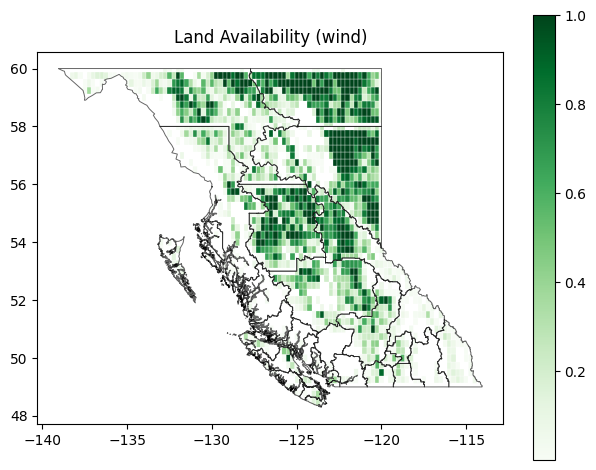

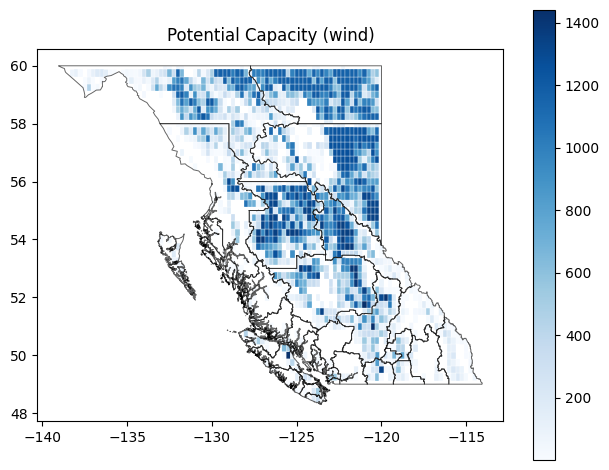

In [11]:
# 2 Calculate Potential Capacity for Cells
## 2.1-2.2
# ERA5_Land_cells_noExclusion=calculate_land_availability_raster(cutout,province_grid_cells,' Excluding exclusion areas',gaez_exclusionAreas_raster,'1_land_avail_exclAreas',exclusionAreas__class_exclusion,actual_area_ROI, buffer=exclusionAreas__class_exclusion_buffer,exclusion=True)
ERA5_Land_cells_low_slop=utils.calculate_land_availability_raster(cutout,province_grid_cells,' Excluding terrain  with >30% slope',gaez_terrain_raster,'2_land_avail_low_slop',terrain_class_exclusion,current_region,buffer=0,exclusion=True)
ERA5_Land_cells_eligible_landclasses=utils.calculate_land_availability_raster(cutout,ERA5_Land_cells_low_slop,' Eligible Land Classes',gaez_landcover_raster,'3_land_avail_eligible',land_class_inclusion,current_region,buffer=0,exclusion=False)

ERA5_Land_cells_nonprotected=utils.calculate_land_availability_vector_data(cutout,ERA5_Land_cells_eligible_landclasses,conservation_lands_province,'Excluding Conservation and Protected lands by Canadian Gov.','4_land_avail_excl_protectedLands',current_region)
ERA5_Land_cells_final=utils.calculate_land_availability_vector_data(cutout,ERA5_Land_cells_nonprotected,aeroway_with_buffer,'Excluding Aeroway with buffer','5_land_avail_excl_aeroway',current_region)
# ERA5_Land_cells_nonaeroway=utils.calculate_land_availability_vector_data(cutout,ERA5_Land_cells_nonprotected,aeroway_with_buffer,'Excluding Aeroway with buffer','5_land_avail_excl_aeroway',current_region)

# ERA5_Land_cells_final=ERA5_Land_cells_eligible_landclasses
ERA5_Land_cells_final['land_availablity']=ERA5_Land_cells_final['eligible_land_area']/ERA5_Land_cells_final['land_area_sq_km']

## vis.plot_data_in_GADM_regions(dataframe,data_column_df,gadm_regions_gdf,color_map,dpi,plt_title,plt_file_name,vis_directory
vis.plot_data_in_GADM_regions(ERA5_Land_cells_final,'land_availablity',
                                gadm_regions_gdf,
                                "Greens",600,f"Land Availability ({resource_type})",
                                f'Land Availability for Potential {resource_type} Plants.png',vis_dir)

## 2.3
province_grid_cells_2=utils.calculate_potential_capacity(ERA5_Land_cells_final,resource_landuse_intensity,'cell')

vis.plot_data_in_GADM_regions(ERA5_Land_cells_final,'potential_capacity',
                                gadm_regions_gdf,
                                "Blues",600,f"Potential Capacity ({resource_type})",
                                f'Land Availability for Potential {resource_type} Plants.png',vis_dir)

In [12]:
# --------------------------Extra steps in WIND MODULE starts here-------------------------------
## 2.4
minimum_site_capacity_mask=province_grid_cells_2['potential_capacity']>=disaggregation_config[f'{resource_type}']['turbines']['OEDB']['model_2']['P'] #nominal power of the turbine
province_grid_cells_3=province_grid_cells_2[minimum_site_capacity_mask]
print(f'FIltered Site : Total {resource_type} Potential (based on available land): {round(province_grid_cells_3.potential_capacity.sum()/1000,2)} GW \n')

FIltered Site : Total wind Potential (based on available land): 754.76 GW 



In [13]:
# 3 Extract Windspeed data from Cutout  
province_grid_cells_4 = wind.impute_ERA5_windspeed_to_Cells(cutout, province_grid_cells_3)

2024-09-18 11:54:48 - INFO - Calculating yearly mean windspeed and imputing to provincial Grid Cells named as 'windspeed_ERA5'


In [14]:
# 4 GWA Cell Processing
## 4.1 Load GWA Cells

gwa_cells_df:pd.DataFrame=pd.read_pickle(province_gwa_cells)
log.info(f"Global Wind Atlas (GWA) Cells loaded. Size: {len(gwa_cells_df)}")

gwa_cells_gdf:gpd.GeoDataFrame = gpd.GeoDataFrame(gwa_cells_df, geometry=gpd.points_from_xy(gwa_cells_df['x'], gwa_cells_df['y']))
log.info(f"Point geometries created for {len(gwa_cells_df)} Cells\n")

gwa_cells_gdf.crs = province_grid_cells.crs
gwa_cells_gdf=gwa_cells_gdf.clip(gadm_regions_gdf,keep_geom_type=False)

gwa_cells_gdf,_=wind.calculate_common_parameters_GWA_cells(gwa_cells_gdf,resource_landuse_intensity)

2024-09-18 11:55:08 - INFO - Global Wind Atlas (GWA) Cells loaded. Size: 10003486


2024-09-18 11:55:09 - INFO - Point geometries created for 10003486 Cells

2024-09-18 11:55:16 - INFO - Creating Polygon Geometry for GWA Cells for a Single Cell
2024-09-18 11:55:17 - INFO - Imputing Land Area, Potential Capacity for all GWA Cells


In [15]:
## 4.2 Map GWA cells to ERA5
gwa_cells_mapped_gdf,era5_cells_gdf_mapped=wind.map_GWAcells_to_ERA5cells(gwa_cells_gdf,province_grid_cells_4,resource_landuse_intensity)

Filtered Sites: Total Wind Potential (ERA5 Cells): 560.94 GW
Filtered Sites: Total Wind Potential (GWA Cells): 560.94 GW


In [16]:
## 4.3 Update ERA5 windspeed and CF with mapped GWA Cells
era5_cells_gdf_updated=wind.update_ERA5_params_from_mapped_GWA_cells(era5_cells_gdf_mapped,gwa_cells_mapped_gdf)

2024-09-18 11:56:09 - INFO - Updating ERA5 mean windspeed with mapped GWA Cells' for each cell, labeled as 'windspeed_GWA'
2024-09-18 11:56:09 - INFO - ERA5 mean windspeed and CF updated and labeled as 'windspeed_GWA' , 'CF_mean_GWA' 


In [17]:
# 5 Rescale ERA5 Cutout Windspeed 
### > Each Windspeed Datapoint scaled with Scalar values from GWA Cells
cutout=wind.rescale_ERA5_cutout_windspeed_with_mapped_GWA_cells(cutout,era5_cells_gdf_updated)

2024-09-18 11:56:09 - INFO - Scaling the ERA5 Cell's Windspeed with mapped GWA Cells within each Cell
2024-09-18 11:56:09 - WARNING - !! Memory Intensive Calculation in Progress...
2024-09-18 11:56:09 - WARNING - !! Windspeed Only for the Coordinates associated to filtered ERA5 Cells shall be scaled
2024-09-18 11:59:03 - INFO - Overwriting the scaled windspeed to ERA5 CUTOUT
2024-09-18 11:59:03 - INFO - Scaled Windspeed data for filtered ERA5 Cells loaded to Cutout.


In [18]:
# 6 Find Nearest Grid Node
Gwa_cells_df_GridNode_filtered=wind.find_grid_nodes_GWA_cells(buses_gdf,gwa_cells_mapped_gdf,grid_node_proximity_filter)

2024-09-18 11:59:03 - INFO - >> Calculating Nearest Grid Nodes for BC Grid Cells...
Calculating Nearest Stations: 100%|██████████| 1208/1208 [02:34<00:00,  7.80it/s, cell=Stikine_246]              
2024-09-18 12:01:38 - INFO - GWA Cells Filtered based on Proximity to Tx Nodes 
    Size: 1047497



2024-09-18 12:01:38 - INFO - Creating Layout for PV generation from BC Grid Cells...
2024-09-18 12:01:38 - INFO - Calculating Generation timeseries for BC Grid Cells as per the Layout Capacity (MW)...
2024-09-18 12:01:38 - INFO - Selected Wind Turbine  Model : 3.2M114 NES @ 93.0m Hub Height
2024-09-18 12:01:38 - INFO - adding a cut-out wind speed to the turbine power curve at V=22.0 m/s.
2024-09-18 12:01:38 - INFO - Convert and aggregate 'wind'.


[########################################] | 100% Completed | 54.38 s


/local-scratch/localhome/mei3/eliasinul/repositories/BC_Combined_Modelling/bc_combined_modelling/linking_wind.py:541: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  datetime_index = pd.date_range(start=start_date , end=end_date, freq='H')
2024-09-18 12:02:39 - INFO - Calculating CF mean from the 8760 data points for each Cell ...
/localhome/mei3/miniconda3/envs/Linking/lib/python3.12/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
2024-09-18 12:02:40 - INFO - Plot Created for CF_mean (wind) for Potential Plants and Save to vis/linking/wind/CF_mean of Potential wind Plants.png


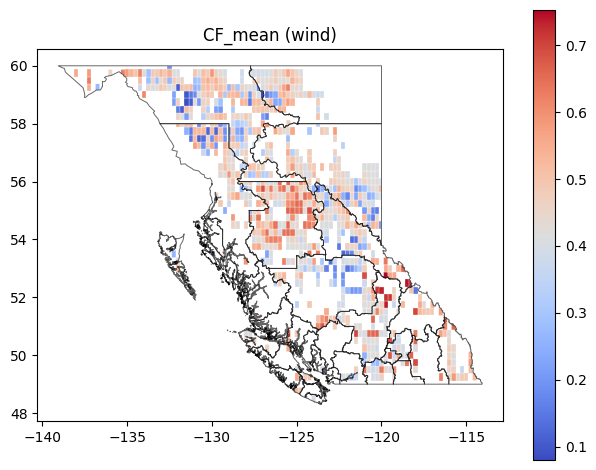

In [19]:
# 7 Create CF timeseries
# arguments: cutout,start_date,end_date,geodataframe_sites,turbine_model,turbine_config_file,Site_index,config='OEDB'):
province_grid_CF_cells,province_grid_CF_ts_df= wind.create_CF_timeseries_df(cutout,start_date,end_date,era5_cells_gdf_updated,turbine_model,turbine_config_file,'cell','OEDB')

zero_CF_mask=province_grid_CF_cells.CF_mean_atlite>0
province_grid_CF_cells= province_grid_CF_cells[zero_CF_mask]

province_grid_CF_cells.loc[:,'capex']=wind_capex

province_grid_CF_cells=utils.assign_regional_cell_ids(province_grid_CF_cells,'Region','cell')
province_grid_CF_cells.to_pickle(os.path.join(linking_data['root'],resource_type,'province_grid_CF_cells.pkl'))

province_grid_CF_ts_df.to_pickle(os.path.join(linking_data['root'],resource_type,linking_data[f'{resource_type}']['ERA5_CF_ts']))
# Visualize
vis.plot_data_in_GADM_regions(province_grid_CF_cells,'CF_mean_atlite',
                            gadm_regions_gdf,
                            'coolwarm',600,f'CF_mean ({resource_type})',
                            f'CF_mean of Potential {resource_type} Plants.png',vis_dir)

In [20]:
# 8 Calculate Scores for Cells
gwa_cells_scored=utils.calculate_cell_score(Gwa_cells_df_GridNode_filtered,grid_connection_cost_per_Km,tx_line_rebuild_cost,'CF_IEC3',wind_capex)
# gwa_cells_scored['CF_mean'] = gwa_cells_scored['ERA5_cell_index'].map(province_grid_CF_cells['CF_mean_atlite'])

#  Save Local File
pickle_file_name = linking_data[f'{resource_type}']['scored_cells']
gwa_cells_scored.to_pickle(os.path.join(linking_data['root'],resource_type,pickle_file_name))

>> Calculating Score for each Cell ...


In [32]:
# 9 Find optimal number of Clusters from K-means clustering 
###  > k-means clustering based on the Scores of cells in each region.

## 9.1-9.3
GWA_cells_cluster_map,region_wind_optimal_k_df = utils.cells_to_cluster_mapping(gwa_cells_scored,vis_dir,wcss_tolerance)

>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone Peace River - Optimal k for p_lcoe based clustering: 3

>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone Mount Waddington - Optimal k for p_lcoe based clustering: 4

>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone East Kootenay - Optimal k for p_lcoe based clustering: 3

>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone Thompson-Nicola - Optimal k for p_lcoe based clustering: 3

>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone Cariboo - Optimal k for p_lcoe based clustering: 3

>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone Bulkley-Nechako - Optimal k for p_lcoe based clustering: 3

>> Estimating optimal number of Clusters for each region ba

/local-scratch/localhome/mei3/eliasinul/repositories/Bidirectional_Linking_Tool/src/linkingtool/linking_utility.py:629: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  region_optimal_k_df['Optimal_k'].fillna(0, inplace=True)


Optimal-k based on 'p_lcoe' clustering calculated for 28 zones and saved to cell dataframe.

>>> Mapping the Optimal Number of Clusters for Each region ...


In [33]:
# 10 Create Clusters
cell_cluster_gdf, dissolved_indices = utils.create_cells_Union_in_clusters(GWA_cells_cluster_map, region_wind_optimal_k_df)

dissolved_indices_save_to=os.path.join(linking_data['root'],resource_type,linking_data[f'{resource_type}']['dissolved_indices'])
utils.dict_to_pickle(dissolved_indices,dissolved_indices_save_to)

2024-09-18 12:32:35 - INFO -  Preparing Clusters...
2024-09-18 12:32:35 - INFO -  Creating cluster for Peace River 1/27
2024-09-18 12:32:36 - INFO -  Creating cluster for Mount Waddington 2/27
2024-09-18 12:32:36 - INFO -  Creating cluster for East Kootenay 3/27
2024-09-18 12:32:36 - INFO -  Creating cluster for Thompson-Nicola 4/27
2024-09-18 12:32:36 - INFO -  Creating cluster for Cariboo 5/27
2024-09-18 12:32:36 - INFO -  Creating cluster for Bulkley-Nechako 6/27
2024-09-18 12:32:37 - INFO -  Creating cluster for Kitimat-Stikine 7/27
2024-09-18 12:32:37 - INFO -  Creating cluster for Okanagan-Similkameen 8/27
2024-09-18 12:32:37 - INFO -  Creating cluster for Kootenay Boundary 9/27
2024-09-18 12:32:37 - INFO -  Creating cluster for Central Okanagan 10/27
2024-09-18 12:32:37 - INFO -  Creating cluster for Fraser-Fort George 11/27
2024-09-18 12:32:38 - INFO -  Creating cluster for Fraser Valley 12/27
2024-09-18 12:32:38 - INFO -  Creating cluster for Cowichan Valley 13/27
2024-09-18 1

In [37]:
## 10.1
minimum_site_capacity_mask=cell_cluster_gdf['potential_capacity']>=disaggregation_config[f'{resource_type}']['turbines']['OEDB']['model_2']['P'] #nominal power of the turbine
cell_cluster_gdf_filtered=cell_cluster_gdf[minimum_site_capacity_mask]

log.info(f'FIltered Clusters : Total {resource_type} Potential : {round(cell_cluster_gdf_filtered.potential_capacity.sum()/1000,2)} GW \n')

## 10.2
cell_cluster_gdf_filtered_c=utils.clip_cluster_boundaries_upto_regions(cell_cluster_gdf_filtered,gadm_regions_gdf)

cell_cluster_gdf_filtered_c['fom']=wind_fom
cell_cluster_gdf_filtered_c['vom']=wind_vom

save_to=os.path.join(linking_data['root'],resource_type,linking_data[f'{resource_type}']['cell_clusters'])
cell_cluster_gdf_filtered_c.to_pickle(save_to)

log.info(f"{len(cell_cluster_gdf)} {resource_type} Sites' Clusters Generated.\n Total Capacity : {cell_cluster_gdf.potential_capacity.sum()/1E3} GW")

log.info (f" {resource_type} Module Execution Completed !")


# ### >>>>>>>>>>>> ----------- Notebook run ends here

2024-09-18 12:33:29 - INFO - FIltered Clusters : Total wind Potential : 340.66 GW 

2024-09-18 12:33:30 - INFO - 83 wind Sites' Clusters Generated.
 Total Capacity : 340.6573456701265 GW
2024-09-18 12:33:30 - INFO -  wind Module Execution Completed !


# skip this for notebook run

In [ ]:
     
    # End the script run  timer
    script_end_time = time.time()

    # Calculate runtime in seconds
    runtime = round((script_end_time - script_start_time),2)
    
    return log.info (f"Script runtime: {runtime} seconds")

if __name__ == "__main__":

    # Set up argument parsing
    parser = argparse.ArgumentParser(description='Run data preparation script')
    parser.add_argument('config', type=str, help=f"Path to the configuration file 'config_master.yml'")
    
    # Parse the arguments
    
    #----------------Main code to be used ----------------
    args = parser.parse_args()
    main(args.config)
    
    # ----------------------- for notebook run/Debugging------------------------------------
    # config_file_path='config/config_master.yml'
    # main(config_file_path)